# Unsupervised Reports
- Display-only notebook for viewing saved results, plots, and interpretations for K-Means, DBSCAN, and CLARANS.
- Reads outputs from `f:/DATA/results/unsupervised/` produced by the clustering notebook.
- Each section clearly states the model and explains what the plot means.

In [25]:
# Setup: paths, imports, and data loading if needed
import json, os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score

OUT_DIR = Path('f:/DATA/results/unsupervised')
DATA_PATH = Path('f:/DATA/DATA_CLEANED/processed/engineered_features_scaled.csv')

df = None
if DATA_PATH.exists():
    try:
        df = pd.read_csv(DATA_PATH)
        print('Loaded data:', DATA_PATH)
    except Exception as e:
        print('Failed to load data:', e)
else:
    print('Data file not found:', DATA_PATH)

# features used (if saved by clustering notebook)
feat_path = OUT_DIR / 'unsupervised_features.json'
feature_cols = None
if feat_path.exists():
    try:
        feature_cols = json.loads(feat_path.read_text()).get('features')
        print('Feature columns loaded:', feature_cols)
    except Exception as e:
        print('Failed to load feature list:', e)

Loaded data: f:\DATA\DATA_CLEANED\processed\engineered_features_scaled.csv
Feature columns loaded: ['latitude', 'longitude', 'texture_soter_C', 'tmax_max', 'texture_soter_M', 'bsat', 'tmin_mean', 'clay', 'prec_min', 'teb', 'prec_p10', 'tcarbon_eq', 'ruggedness', 'gridcode', 'tmax_p10', 'tmax_std', 'ref_bulk', 'moisture_retention', 't_range', 'elevation']


## K-Means Summary

Model: K-Means — silhouette by k shows separation quality. Higher is generally better.


,k,silhouette,davies_bouldin,calinski_harabasz
0,2,0.341544,1.253483,41326.232822
1,3,0.241600,1.778366,24368.721005
2,4,0.250038,1.638327,24438.145924
3,5,0.264260,1.607549,21898.395932
4,6,0.276923,1.541776,20751.585419


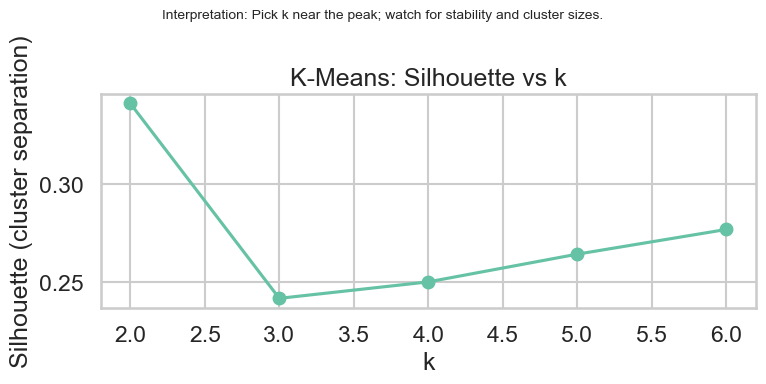

Best k (saved): 2
K-Means labels loaded: 71050


In [26]:
# Load K-Means outputs and visualize
sum_path = OUT_DIR / 'kmeans_summary.json'
lab_path = OUT_DIR / 'kmeans_labels.csv'
print('Model: K-Means — silhouette by k shows separation quality. Higher is generally better.')
if sum_path.exists():
    try:
        km_summary = json.loads(sum_path.read_text())
        results = km_summary.get('results', {})
        rows = []
        for k, res in results.items():
            m = res.get('metrics', {})
            rows.append({'k': int(k), 'silhouette': m.get('silhouette'), 'davies_bouldin': m.get('davies_bouldin'), 'calinski_harabasz': m.get('calinski_harabasz')})
        dfk = pd.DataFrame(rows).sort_values('k')
        display(dfk)
        # silhouette vs k
        plt.figure(figsize=(8,4))
        plt.plot(dfk['k'], dfk['silhouette'], marker='o')
        plt.xlabel('k')
        plt.ylabel('Silhouette (cluster separation)')
        plt.title('K-Means: Silhouette vs k')
        plt.suptitle('Interpretation: Pick k near the peak; watch for stability and cluster sizes.', fontsize=10, y=0.98)
        plt.tight_layout(); plt.show()
        print('Best k (saved):', km_summary.get('best_k'))
    except Exception as e:
        print('Failed to parse K-Means summary:', e)
else:
    print('K-Means summary not found:', sum_path)

km_labels = None
if lab_path.exists():
    try:
        km_labels = pd.read_csv(lab_path)['cluster_label'].values
        print('K-Means labels loaded:', len(km_labels))
    except Exception as e:
        print('Failed to read K-Means labels:', e)

## DBSCAN Summary

Model: DBSCAN — density-based clustering. Heatmaps show how parameters affect silhouette and noise.


,eps,min_samples,n_clusters,noise_rate,silhouette
23,2.0,20,156,0.019648,0.204592
22,2.0,15,165,0.013765,0.202930
21,2.0,10,183,0.007502,0.201656
20,2.0,5,221,0.003139,0.194465
19,1.5,20,238,0.052048,0.241598
18,1.5,15,262,0.035384,0.242777
15,1.2,20,283,0.101154,0.208680
17,1.5,10,300,0.020873,0.243170
14,1.2,15,343,0.074089,0.206975
11,1.0,20,365,0.147080,0.248331


Best (saved): {'eps': 2.0, 'min_samples': 20, 'silhouette': 0.20459187511314328}


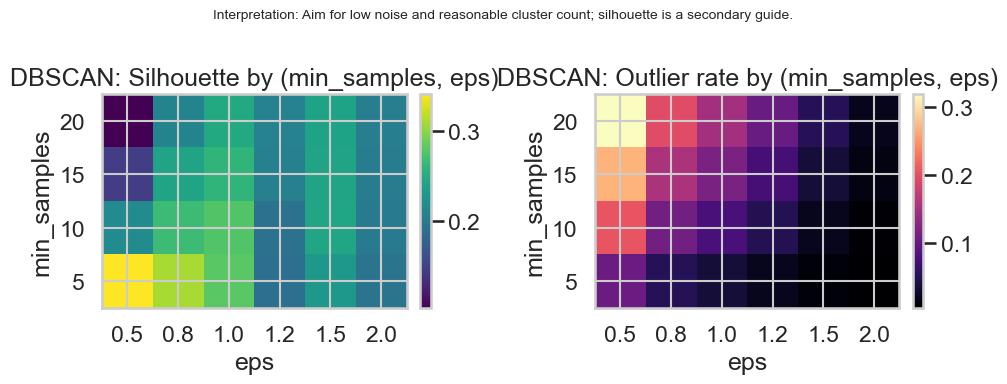

DBSCAN labels loaded: 71050


In [27]:
# Load DBSCAN outputs and visualize
sum_path = OUT_DIR / 'dbscan_summary.json'
lab_path = OUT_DIR / 'dbscan_labels.csv'
print('Model: DBSCAN — density-based clustering. Heatmaps show how parameters affect silhouette and noise.')
db_runs = None
if sum_path.exists():
    try:
        db_summary = json.loads(sum_path.read_text())
        best = db_summary.get('best')
        runs = db_summary.get('runs', [])
        db_runs = runs
        rows = []
        for r in runs:
            n_clusters = len(set([l for l in r.get('labels', []) if l != -1]))
            noise_rate = (np.array(r.get('labels', [])) == -1).mean() if r.get('labels') else None
            rows.append({'eps': r.get('eps'), 'min_samples': r.get('min_samples'), 'n_clusters': n_clusters, 'noise_rate': noise_rate, 'silhouette': r.get('metrics', {}).get('silhouette')})
        dfr = pd.DataFrame(rows)
        display(dfr.sort_values(['n_clusters','noise_rate'], ascending=[True, True]))
        print('Best (saved):', {'eps': best.get('eps'), 'min_samples': best.get('min_samples'), 'silhouette': best.get('metrics', {}).get('silhouette') if best.get('metrics') else None})
        # Heatmaps if grid exists
        unique_eps = sorted(set([r['eps'] for r in runs])) if runs else []
        unique_ms = sorted(set([r['min_samples'] for r in runs])) if runs else []
        if unique_eps and unique_ms:
            mat_sil = np.full((len(unique_ms), len(unique_eps)), np.nan)
            mat_out = np.full((len(unique_ms), len(unique_eps)), np.nan)
            for r in runs:
                i = unique_ms.index(r['min_samples'])
                j = unique_eps.index(r['eps'])
                sil = r.get('metrics', {}).get('silhouette')
                mat_sil[i, j] = sil if sil is not None else np.nan
                mat_out[i, j] = (np.array(r.get('labels', [])) == -1).mean() if r.get('labels') else np.nan
            fig, axs = plt.subplots(1,2, figsize=(10,4))
            im0 = axs[0].imshow(mat_sil, aspect='auto', cmap='viridis', origin='lower')
            axs[0].set_xticks(range(len(unique_eps))); axs[0].set_xticklabels(unique_eps)
            axs[0].set_yticks(range(len(unique_ms))); axs[0].set_yticklabels(unique_ms)
            axs[0].set_title('DBSCAN: Silhouette by (min_samples, eps)')
            axs[0].set_xlabel('eps'); axs[0].set_ylabel('min_samples')
            fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
            im1 = axs[1].imshow(mat_out, aspect='auto', cmap='magma', origin='lower')
            axs[1].set_xticks(range(len(unique_eps))); axs[1].set_xticklabels(unique_eps)
            axs[1].set_yticks(range(len(unique_ms))); axs[1].set_yticklabels(unique_ms)
            axs[1].set_title('DBSCAN: Outlier rate by (min_samples, eps)')
            axs[1].set_xlabel('eps'); axs[1].set_ylabel('min_samples')
            fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
            fig.suptitle('Interpretation: Aim for low noise and reasonable cluster count; silhouette is a secondary guide.', fontsize=10)
            plt.tight_layout(); plt.show()
    except Exception as e:
        print('Failed to parse DBSCAN summary:', e)
else:
    print('DBSCAN summary not found:', sum_path)

db_labels = None
if lab_path.exists():
    try:
        db_labels = pd.read_csv(lab_path)['cluster_label'].values
        print('DBSCAN labels loaded:', len(db_labels))
    except Exception as e:
        print('Failed to read DBSCAN labels:', e)

## CLARANS Summary

Model: CLARANS (medoids, sampled) — silhouette by k approximates separation on the sample.


,k,silhouette,cost,sample_n
0,2,0.335157,225427.765625,20000
1,3,0.313964,194094.312500,20000
2,4,0.341590,166135.859375,20000
3,5,0.281803,150375.093750,20000


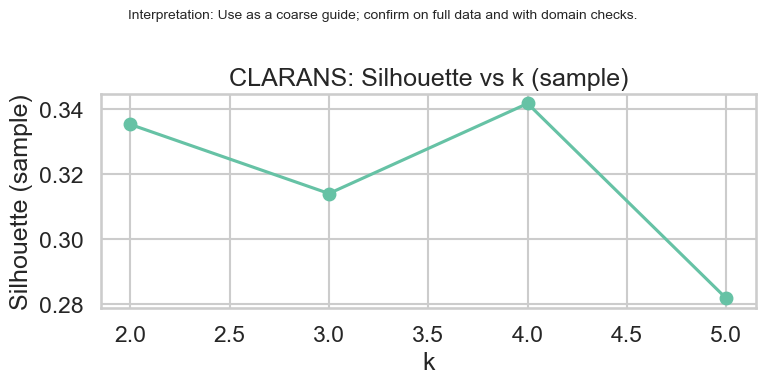

Best k: 4 | silhouette: 0.34158984936425857 | sample_n: 20000
Half-good verdict: YES | tiny clusters: 0


In [28]:
# Load CLARANS summary and plot
sum_path = OUT_DIR / 'clarans_summary.json'
print('Model: CLARANS (medoids, sampled) — silhouette by k approximates separation on the sample.')
clarans_runs = None
if sum_path.exists():
    try:
        clarans_summary = json.loads(sum_path.read_text())
        runs = clarans_summary.get('runs', {})
        rows = []
        for k_str, r in runs.items():
            k = int(k_str)
            sil = r.get('metrics', {}).get('silhouette')
            cost = r.get('best', {}).get('cost')
            sample_n = r.get('sample_n')
            rows.append({'k': k, 'silhouette': sil, 'cost': cost, 'sample_n': sample_n})
        dfk = pd.DataFrame(rows).sort_values('k')
        display(dfk)
        plt.figure(figsize=(8,4))
        plt.plot(dfk['k'], dfk['silhouette'], marker='o')
        plt.xlabel('k')
        plt.ylabel('Silhouette (sample)')
        plt.title('CLARANS: Silhouette vs k (sample)')
        plt.suptitle('Interpretation: Use as a coarse guide; confirm on full data and with domain checks.', fontsize=10, y=0.98)
        plt.tight_layout(); plt.show()
        clarans_runs = runs
        # verdict
        if len(dfk):
            best_row = dfk.loc[dfk['silhouette'].idxmax()] if dfk['silhouette'].notna().any() else dfk.iloc[0]
            print('Best k:', int(best_row['k']), '| silhouette:', best_row['silhouette'], '| sample_n:', int(best_row['sample_n']))
            k_best = int(best_row['k'])
            labels = np.array(runs[str(k_best)]['best']['assign']) if runs and str(k_best) in runs else None
            if labels is not None:
                counts = pd.Series(labels).value_counts().sort_index()
                tiny = (counts < max(5, 0.005*len(labels))).sum()
                verdict = (best_row['silhouette'] is not None and best_row['silhouette'] >= 0.1 and tiny == 0)
                print('Half-good verdict:', 'YES' if verdict else 'NO', '| tiny clusters:', int(tiny))
    except Exception as e:
        print('Failed to parse CLARANS summary:', e)
else:
    print('CLARANS summary not found:', sum_path)

## Interpretations

Cluster counts: {0: 11704, 1: 33686, 2: 11132, 3: 14528}


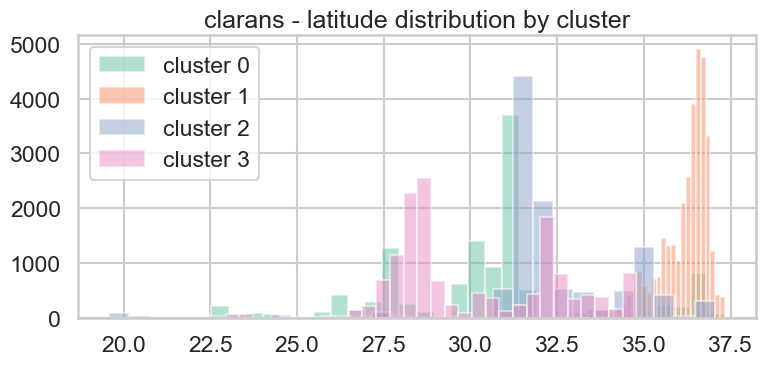

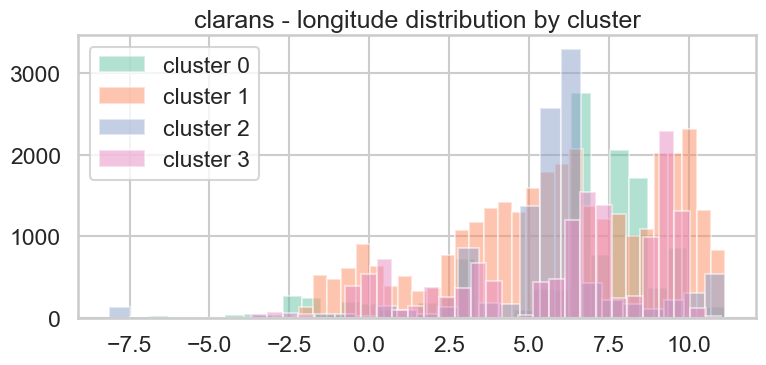

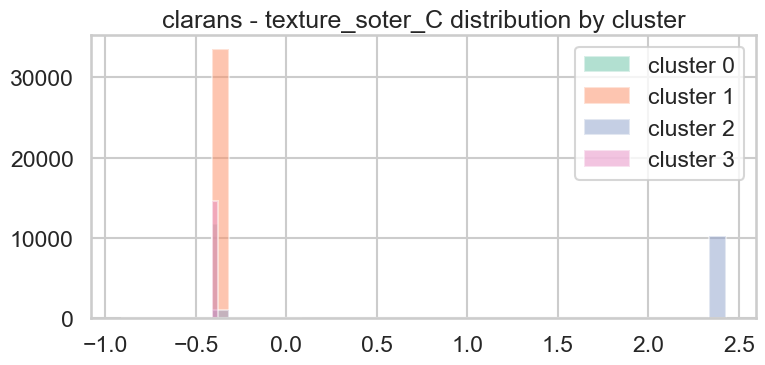

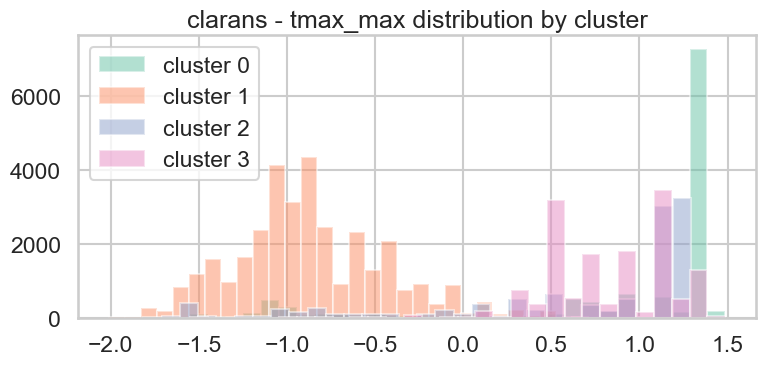

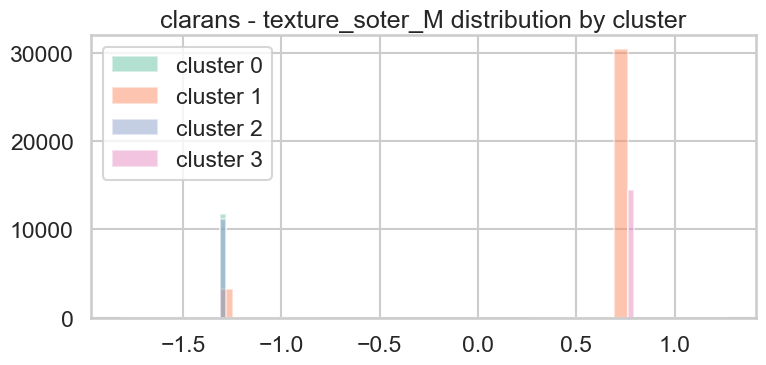

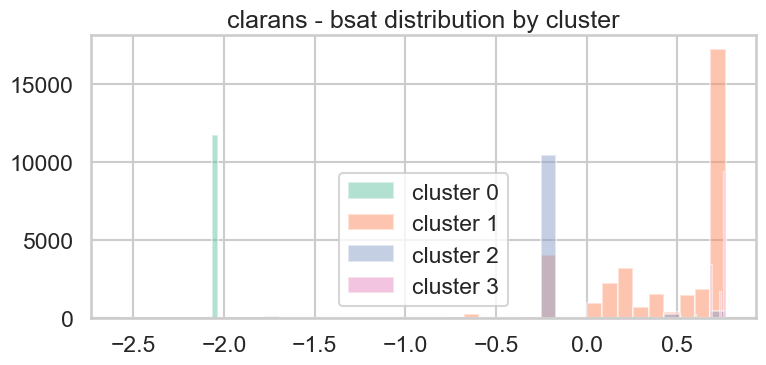

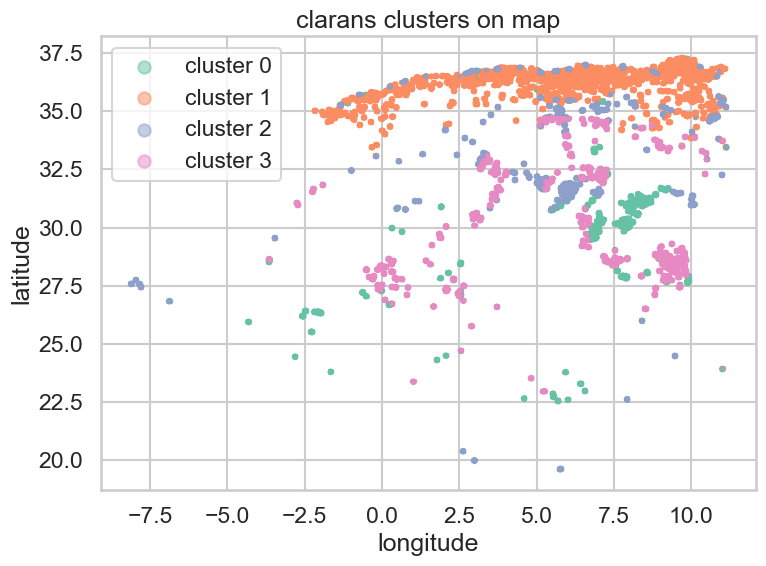

Interpretation artifacts saved to: f:\DATA\results\unsupervised


In [32]:
# Build interpretations using whichever labels exist (prefer DBSCAN, then KMeans)
# labels_dbscan = OUT_DIR / 'dbscan_labels.csv'
# labels_kmeans = OUT_DIR / 'kmeans_labels.csv'
labels_clarans = OUT_DIR / 'clarans_labels.csv'
label_df = None; chosen = None
# if labels_dbscan.exists():
#     label_df = pd.read_csv(labels_dbscan); chosen = 'dbscan'
# if labels_kmeans.exists():
#     label_df = pd.read_csv(labels_kmeans); chosen = 'kmeans'
if labels_clarans.exists():
    label_df = pd.read_csv(labels_clarans); chosen = 'clarans'
else:
    print('No labels found under', OUT_DIR)

if label_df is not None and df is not None:
    df_labels = df.copy()
    df_labels['cluster_label'] = label_df['cluster_label'].values
    counts = df_labels['cluster_label'].value_counts().sort_index()
    print('Cluster counts:', counts.to_dict())
    if feature_cols is None:
        # fallback: top-variance features from df columns excluding target
        cols = [c for c in df_labels.columns if c != 'fire']
        variances = df_labels[cols].var().sort_values(ascending=False)
        feature_cols = list(variances.head(20).index)
    stats = {}
    for cl in sorted(df_labels['cluster_label'].unique()):
        sub = df_labels[df_labels['cluster_label'] == cl]
        desc = sub[feature_cols].agg(['min','mean','max']).T
        stats[int(cl)] = {feat: {'min': float(desc.loc[feat,'min']), 'mean': float(desc.loc[feat,'mean']), 'max': float(desc.loc[feat,'max'])} for feat in feature_cols}
    Path(OUT_DIR / f'{chosen}_interpretation.json').write_text(json.dumps({'counts': {int(k): int(v) for k,v in counts.items()}, 'feature_stats': stats}, indent=2))
    # Save CSV of feature ranges
    rows = []
    for cl, feats in stats.items():
        for feat, vals in feats.items():
            rows.append({'cluster': cl, 'feature': feat, 'min': vals['min'], 'mean': vals['mean'], 'max': vals['max']})
    pd.DataFrame(rows).to_csv(OUT_DIR / f'{chosen}_feature_ranges.csv', index=False)
    # Plots: histogram of a few top-variance features per cluster
    top_feats = feature_cols[:6]
    for feat in top_feats:
        plt.figure(figsize=(8,4))
        for cl in sorted(df_labels['cluster_label'].unique()):
            sub = df_labels[df_labels['cluster_label'] == cl]
            plt.hist(sub[feat], bins=30, alpha=0.5, label=f'cluster {cl}')
        plt.title(f'{chosen} - {feat} distribution by cluster')
        plt.legend(); plt.tight_layout(); plt.show()
    # Scatter plot if coordinates exist
    if {'latitude','longitude'}.issubset(df_labels.columns):
        plt.figure(figsize=(8,6))
        for cl in sorted(df_labels['cluster_label'].unique()):
            sub = df_labels[df_labels['cluster_label'] == cl]
            plt.scatter(sub['longitude'], sub['latitude'], s=5, alpha=0.5, label=f'cluster {cl}')
        plt.xlabel('longitude'); plt.ylabel('latitude')
        plt.title(f'{chosen} clusters on map')
        plt.legend(markerscale=4); plt.tight_layout(); plt.show()
    print('Interpretation artifacts saved to:', OUT_DIR)
else:
    print('Missing data or labels; skipping interpretations.')

## Alignment (Optional)

In [34]:
# Report-only alignment of clusters vs fire (no leakage into modeling)
# labels_dbscan = OUT_DIR / 'dbscan_labels.csv'
# labels_kmeans = OUT_DIR / 'kmeans_labels.csv'
labels_clarans = OUT_DIR / 'kmedoids_labels.csv'
label_df = None; chosen = None
# if labels_dbscan.exists():
#     label_df = pd.read_csv(labels_dbscan); chosen = 'dbscan'
# if labels_kmeans.exists():
#     label_df = pd.read_csv(labels_kmeans); chosen = 'kmeans'
if labels_clarans.exists():
    label_df = pd.read_csv(labels_clarans); chosen = 'clarans'
if label_df is not None and df is not None and 'fire' in df.columns:
    df_align = df.copy()
    df_align['cluster_label'] = label_df['cluster_label'].values
    ari = adjusted_rand_score(df_align['fire'], df_align['cluster_label'])
    ami = adjusted_mutual_info_score(df_align['fire'], df_align['cluster_label'])
    hom = homogeneity_score(df_align['fire'], df_align['cluster_label'])
    comp = completeness_score(df_align['fire'], df_align['cluster_label'])
    print({'method': chosen, 'ARI': ari, 'AMI': ami, 'homogeneity': hom, 'completeness': comp})
    rates = df_align.groupby('cluster_label')['fire'].mean().to_dict()
    counts = df_align['cluster_label'].value_counts().sort_index().to_dict()
    print({'counts': counts, 'fire_rate_per_cluster': rates})
else:
    print('Fire label not available or no labels found; skipping alignment metrics.')

{'method': 'clarans', 'ARI': 0.11408739739548462, 'AMI': np.float64(0.05739285282814984), 'homogeneity': np.float64(0.10078442066843372), 'completeness': np.float64(0.04014190218758638)}
{'counts': {0: 11594, 1: 34515, 2: 11527, 3: 13414}, 'fire_rate_per_cluster': {0: 0.3568224943936519, 1: 0.07982036795596117, 2: 0.3675717879760562, 3: 0.22968540330997464}}


## What You'll See
- Which model outputs are available (K-Means, DBSCAN, CLARANS).
- For each available model:
  - A summary table of parameters and metrics.
  - A labeled plot with a short explanation of what it indicates.
- If something is missing, you'll get a clear message telling you what to run in the clustering notebook.

In [ ]:
# Availability Check
from pathlib import Path
OUT_DIR = Path('f:/DATA/results/unsupervised')
files = {
    'kmeans_summary': OUT_DIR / 'kmeans_summary.json',
    'kmeans_labels': OUT_DIR / 'kmeans_labels.csv',
    'dbscan_summary': OUT_DIR / 'dbscan_summary.json',
    'dbscan_labels': OUT_DIR / 'dbscan_labels.csv',
    'clarans_summary': OUT_DIR / 'clarans_summary.json',
    'clarans_labels': OUT_DIR / 'clarans_labels.csv',
}
avail = {k: p.exists() for k,p in files.items()}
print('Available outputs:')
for k, ok in avail.items():
    print(f' - {k}:', 'FOUND' if ok else 'missing')
if not any(avail.values()):
    print('No saved outputs found. Run the clustering notebook to generate results.')
else:
    print('Proceeding to show plots for any FOUND models.')